# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.ascii_uppercase
undistinct = 'CKOPSVZ'
chars = characters
for i in characters:
    if i not in undistinct:
        chars += i.lower()
print(chars)

width, height, n_len, n_class = 130, 53, 4, len(chars)
path = os.getcwd() + '/sample3'
print path

ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghijlmnqrtuwxy
/home/z/gtest/captcha_break/sample3


# 定义数据生成器

In [7]:
root, dirs, files = os.walk(path).next()

def getAllImages(path):
    cnt = len(files)
    X = np.zeros((cnt, height, width, 3), dtype=np.uint8)
    y = []
    for i, j in enumerate(files):
        X[i] = cv2.imread(root+'/'+j)
        y.append(j[:4])
    return X, y

allX, ally = getAllImages(path)

def gen(batch_size=8):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    cnt = 0
    while True:
        for i in range(batch_size):
            X[i] = allX[cnt]
            for j, ch in enumerate(ally[cnt]):
                y[j][i, :] = 0
                y[j][i, chars.find(ch)] = 1
            if cnt >= len(files) - 1:
                cnt = 0
            else:
                cnt += 1
        yield X, y

# 测试生成器

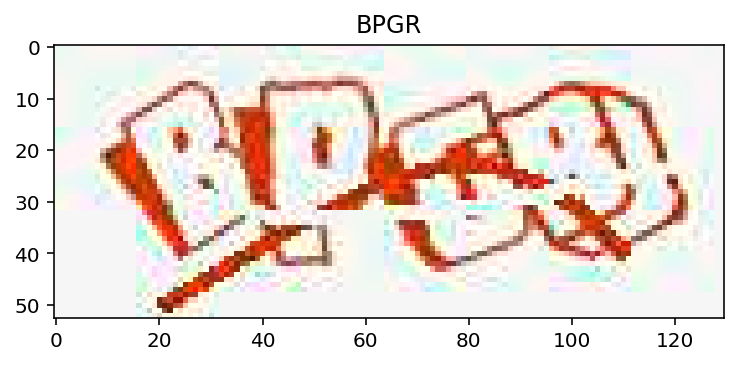

In [8]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([chars[x] for x in y])
a = gen(1)
X, y = a.next()
plt.imshow(X[0])
plt.title(decode(y))

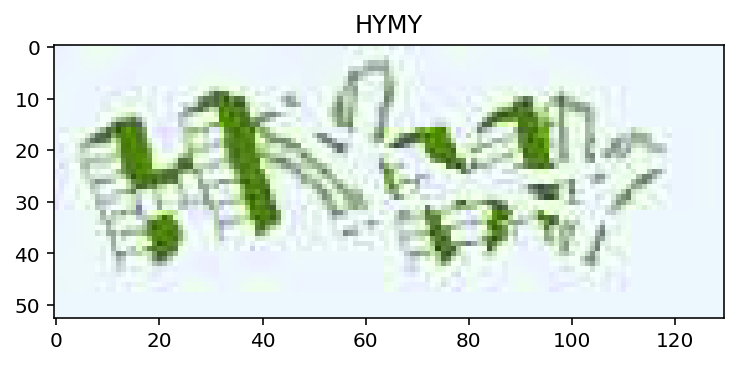

In [16]:
X, y = a.next()
plt.imshow(X[0])
plt.title(decode(y))

# 定义网络结构

In [17]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
#for i in range(4):
    #x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    #x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    #x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Using TensorFlow backend.


# 网络结构可视化

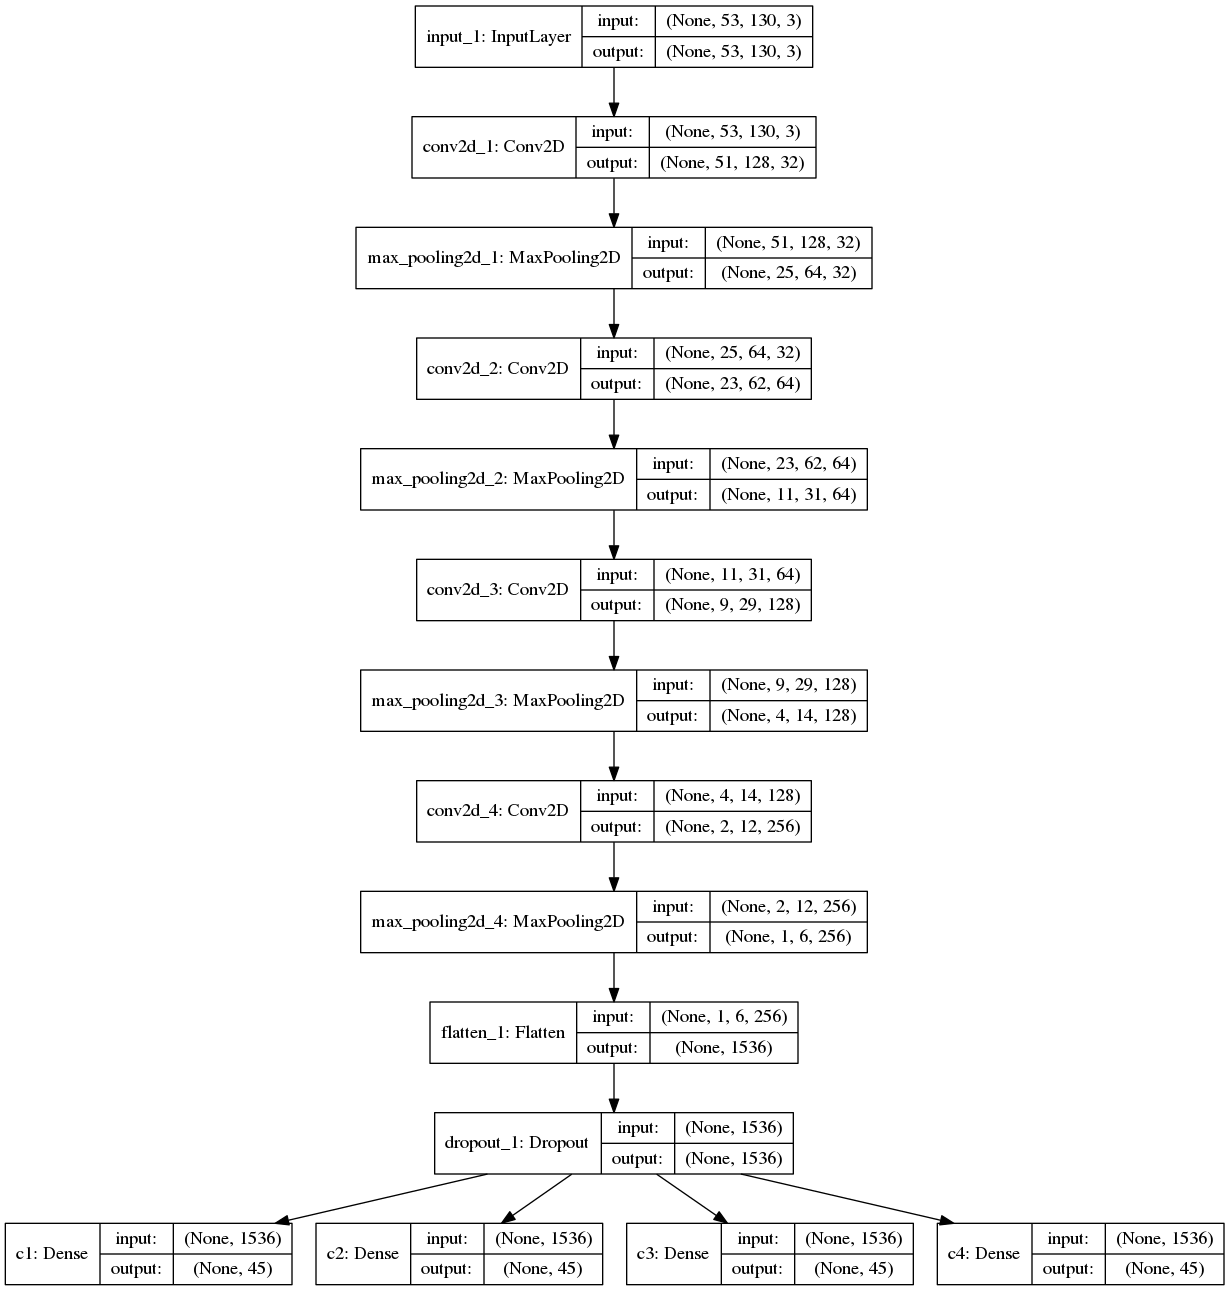

In [18]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [19]:
model.fit_generator(gen(), steps_per_epoch=10, epochs=5,
                    validation_data=gen(), validation_steps=30)

Epoch 1/5
10/10 [==============================] - 7s - loss: 60.7753 - c1_loss: 14.7829 - c2_loss: 15.0972 - c3_loss: 14.9786 - c4_loss: 15.9166 - c1_acc: 0.0750 - c2_acc: 0.0625 - c3_acc: 0.0625 - c4_acc: 0.0125 - val_loss: 61.9203 - val_c1_loss: 15.1107 - val_c2_loss: 15.4465 - val_c3_loss: 15.5808 - val_c4_loss: 15.7823 - val_c1_acc: 0.0625 - val_c2_acc: 0.0417 - val_c3_acc: 0.0333 - val_c4_acc: 0.0208

# 测试模型

In [20]:
a = gen(1)

(-0.5, 129.5, 52.5, -0.5)

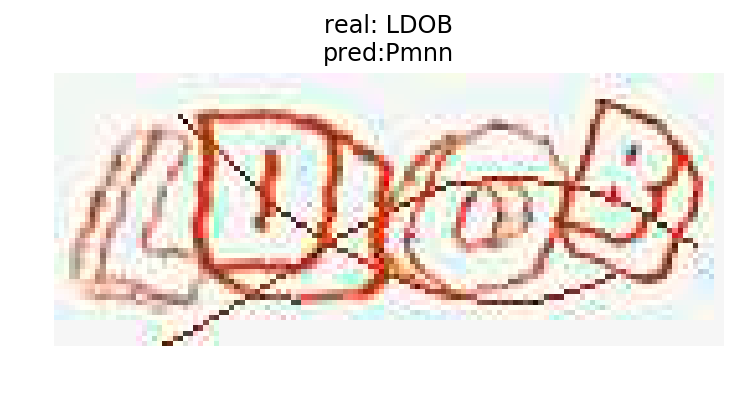

In [74]:
X, y = a.next()
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [9]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 20/20 [00:09<00:00,  2.38it/s]


0.0

# 保存模型

In [10]:
model.save('cnn.h5')